In [1]:
#conda install -c conda-forge ipywidgets
#conda install nodejs
#jupyter labextension install @jupyter-widgets/jupyterlab-manager

import os, shutil, subprocess
import pandas as pd
from ipywidgets import widgets
from ipywidgets import interact
from IPython.display import display
from math import floor
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

%matplotlib notebook

# Set atoms for colvars

In [2]:

pdbFile = "./setup/decarboxylase.0.pdb"
psfFile = "./setup/decarboxylase.0.psf"

dcdFile = "./SMD_Data/min_smd.dcd"
xstFile = "./SMD_Data/min_smd.xst"

atomDistList = []

### Decarboxylase

atomDistList.append( (3311,3312,"OMP C6 <-> OMP C7") )
atomDistList.append( (3311,1020,"OMP C6 <-> Lys61 HZ1") )
atomDistList.append( (3314,980,"OMP OA <-> Asp59 OD2") )
atomDistList.append( (3313,979,"OMP OB <-> Asp59 OD1") )

atomDistList

[(3311, 3312, 'OMP C6 <-> OMP C7'),
 (3311, 1020, 'OMP C6 <-> Lys61 HZ1'),
 (3314, 980, 'OMP OA <-> Asp59 OD2'),
 (3313, 979, 'OMP OB <-> Asp59 OD1')]

# Set paths for tools used along the tutorial

In [3]:

catdcdPath = "catdcd"
#catdcdPath = "/Applications/VMD\ 1.9.4.app/Contents/vmd/plugins/MACOSXX86/bin/catdcd5.2/catdcd"


# Create TCL that loads DCD and calculates colvar values over trajectory to save in a CSV.

In [6]:
tclOut = open("./tmp/calc_distances.tcl","w")

# Creates strings that will be written to a TCL file, and executed by VMD
fileStrings = []

# Loads PSF and DCD files
fileStrings.append("set molID [ mol new " + psfFile + "] \n")
#fileStrings.append("mol addfile " + pdbFile + "\n")
fileStrings.append("mol addfile " + dcdFile + " waitfor all molid $molID \n")

# Gets number of frames and opens CSV output file.
fileStrings.append("""

set numFrames [molinfo $molID get numframes]

puts \"Number of frames: $numFrames\"

set fpCVDat [open "cv_data.csv" w]

""")

# Sets the distance tracking for the chosen pairs of atoms, and create variables for plotting and analysis.
headerStr = ""
distStr = ""
keyNameDic = {}
measureStrings = []
for indx in range(len(atomDistList)):
    
    distSel = atomDistList[indx]
    measureStrings.append("\t# Distance " + str(indx) + ": " + str(distSel[2]) + "\n")
    measureStrings.append("\tset dist" + str(indx) + " [ measure bond {" + str(distSel[0]) + " " + \
                          str(distSel[1]) + "} molid $molID ] \n\n")
    
    if indx > 0:
        comma = ","
    else:
        comma = ""
    distStr += comma + "$dist" + str(indx)
    headerStr += comma + "dist" + str(indx)
    
    keyNameDic["dist"+str(indx)] = str(distSel[2])


# Writes header to CSV file
fileStrings.append("puts $fpCVDat \"" + headerStr + "\" \n")

# Initiates loop for ColVar tracking.
fileStrings.append("""

for {set frame 0} {$frame < $numFrames} {incr frame} { 

    animate goto $frame
    
""")

# Adds lines that calculate atom distances.
fileStrings += measureStrings

# Writes distance data to CSV file
fileStrings.append("\tputs $fpCVDat \"" + distStr + "\" \n")

# Ends loop and closes CSV file
fileStrings.append("""
}

close $fpCVDat 

""" )

tclOut.writelines(fileStrings)

tclOut.close()

# Run VMD with TCL script

In [13]:
%%bash

#/Applications/VMD\ 1.9.4.app/Contents/Resources/VMD.app/Contents/MacOS/vmd -dispdev text -e ./tmp/calc_distances.tcl
vmd -dispdev text -e ./tmp/calc_distances.tcl

Info) VMD for LINUXAMD64, version 1.9.4a7 (July 12, 2017)
Info) http://www.ks.uiuc.edu/Research/vmd/                         
Info) Email questions and bug reports to vmd@ks.uiuc.edu           
Info) Please include this reference in published work using VMD:   
Info)    Humphrey, W., Dalke, A. and Schulten, K., `VMD - Visual   
Info)    Molecular Dynamics', J. Molec. Graphics 1996, 14.1, 33-38.
Info) -------------------------------------------------------------
Info) Multithreading available, 32 CPUs detected.
Info)   CPU features: SSE2 AVX 
Info) Free system memory: 24GB (75%)
Info) No CUDA accelerator devices available.


/usr/local/lib/vmd/vmd_LINUXAMD64: /lib64/libGL.so.1: no version information available (required by /usr/local/lib/vmd/vmd_LINUXAMD64)
bash: line 3: 19627 Segmentation fault      (core dumped) vmd -dispdev text -e ./tmp/calc_distances.tcl


# Load CSV in Python for frame selection
### Explain Pandas
### Explain Melt/Cast

In [68]:
cvDat = pd.read_csv("cv_data.csv")
numFrames = len(cvDat)

cvDatMelt = pd.melt(cvDat, var_name="colvar", value_name="Distance")

VBox(children=(HBox(children=(BoundedIntText(value=3, description='Stride:'), IntSlider(value=3, max=32, min=1, readout=False))), HBox(children=(BoundedIntText(value=10, description='Images:'), IntSlider(value=10, max=32, min=1, readout=False)))))

<IPython.core.display.Javascript object>


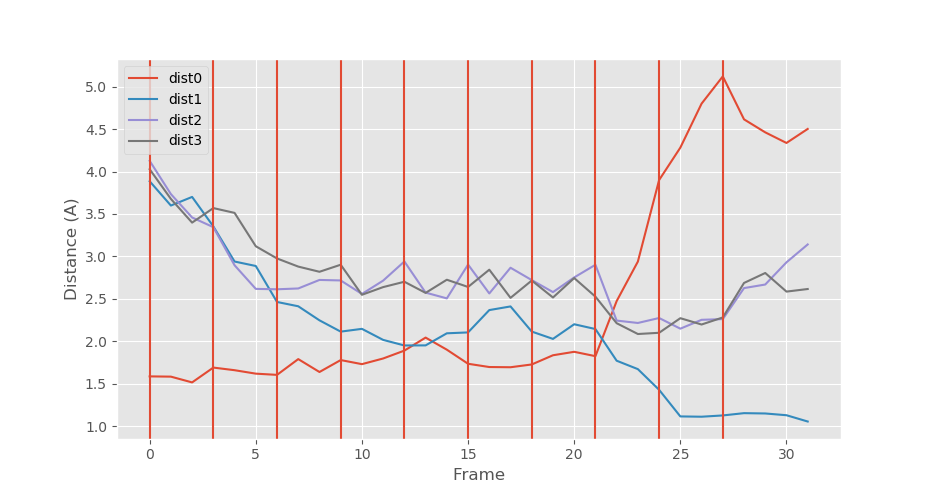

In [110]:
%matplotlib notebook
keyNameDic

# Initializes number of frames between images as one tenth of total frames, rounding down, and 
# making sure we have at least 1 (one) frame
initStride = max(floor(numFrames/10.0),1)
initImgs = floor(numFrames/initStride)

# Sets widgets to select number frames between images
strideText = widgets.BoundedIntText(value=initStride, step=1, description="Stride:")
strideSlider = widgets.IntSlider(value=initStride, step=1, readout=False, min=1, max=numFrames)

mylink = widgets.jslink((strideText, 'value'), (strideSlider, 'value'))

hboxFrames = widgets.HBox([strideText,strideSlider])

# Sets widgets to select number of images
imagesText = widgets.BoundedIntText(value=initImgs, step=1, description="Images:")
imagesSlider = widgets.IntSlider(value=initImgs, step=1, readout=False, min=1, max=numFrames)

mylink = widgets.jslink((imagesText, 'value'), (imagesSlider, 'value'))

hboxImgs = widgets.HBox([imagesText,imagesSlider])

# Connects both inputs
def update_stride(*args):
    strideText.value = max(floor(numFrames/imagesText.value),1) 
imagesText.observe(update_stride, 'value')

def update_images(*args):
    imagesText.value = max(floor(numFrames/strideText.value),1) 
strideText.observe(update_images, 'value')

# Displays both widgets
ui = widgets.VBox([hboxFrames, hboxImgs])
display(ui)

# Build basic plot
xrange = np.arange(0, numFrames, 1)
fig, ax = plt.subplots()
plt.xlabel("Frame")
plt.ylabel("Distance (A)")
plt.show()

# Populate with selected colvar values
for key, grp in cvDatMelt.groupby(['colvar']):
    ax = grp.plot(ax=ax, kind='line', x=xrange, y='Distance', label=key)
    plt.legend()
    plt.draw()

linesList = []

def update_plot(ax):
    
    # Initialize Images on the plot
    xcoords = [i*strideText.value for i in range(0,imagesText.value) ]
    #if xcoords[-1] != (numFrames-1):
    #    xcoords += [numFrames-1]
        
    lineIndx = 0
    
    if ( len(xcoords) > len(linesList) ):
        while lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(xcoords[lineIndx])
            lineIndx += 1
            
        while lineIndx < len(xcoords):
            linesList.append( ax.axvline(x=xcoords[lineIndx]) )
            lineIndx += 1
            
    else:
        while lineIndx < len(xcoords):
            linesList[lineIndx].set_xdata(xcoords[lineIndx])
            lineIndx += 1
            
        while lineIndx < len(linesList):
            linesList[lineIndx].set_xdata(xcoords[0])
            lineIndx += 1
    
    fig.canvas.draw()

def update_data(*args):
    update_plot(ax)

update_plot(ax)

imagesText.observe(update_data, 'value')

plt.show()

# Retreive data from selected frames

In [111]:
frames = [i*strideText.value for i in range(0,imagesText.value) ]
frames

[0, 4, 8, 12, 16, 20, 24, 28]

In [112]:
cvDat.iloc[frames,:]

,dist0,dist1,dist2,dist3
0,1.586534,3.885878,4.126410,4.027398
4,1.659359,2.939909,2.896054,3.513038
8,1.638192,2.247036,2.722897,2.819107
12,1.890284,1.950861,2.940639,2.701603
16,1.696764,2.367765,2.563706,2.843591
20,1.876206,2.200825,2.752546,2.745136
24,3.900064,1.428308,2.274447,2.100228
28,4.615083,1.153320,2.626803,2.687399


# Creates DCD and XSC files to initiate String calculation

In [113]:

setupPath = "String_eABF/setup/"

# Erases setup files if they exist. We start from scratch to avoid future errors.
if os.path.exists("String_eABF"):
    shutil.rmtree("String_eABF")
os.makedirs(setupPath)

print("Total selected frames:",len(frames))

stringFileList = []
stringIndex = 0
for frame in frames:
    
    # Creates a list of DCD files that will be used to write configuration files for the String.
    stringFileList.append("string_"+str(stringIndex)+".dcd")
    
    # Writes selected frames to DCD files for String input
    print("Writing frame " + str(frame) + " to file " + stringFileList[-1])
    command = catdcdPath + " -o " + setupPath + stringFileList[-1] + \
        " -first " + str(frame) + " -last " + str(frame+1) + " " + dcdFile
    subprocess.run(command, shell=True, check=True)
    
    # Exact frames from the XST file for String input
    sedFile = setupPath + "string_" + str(stringIndex) + ".xsc"
    sedLine = "sed -n " + str(frame + 1) + "p " + xstFile + " > " + sedFile 
    subprocess.run(sedLine, shell=True, check=True)
    
    stringIndex += 1


Total selected frames: 8
Writing frame 0 to file string_0.dcd
Writing frame 4 to file string_1.dcd
Writing frame 8 to file string_2.dcd
Writing frame 12 to file string_3.dcd
Writing frame 16 to file string_4.dcd
Writing frame 20 to file string_5.dcd
Writing frame 24 to file string_6.dcd
Writing frame 28 to file string_7.dcd


# Creates Configuration files to initiate String calculation

### We create configuration files for both String and eABF because we already have all the necessary data and parameters for both, but the eABF calculation will still need structural data that we will gather from the results of the String optimization.